# Frequency Shifter

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', 'Waves', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from waves.sound import *
from waves.tools.dsp.mixers.frequency_mixers import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings 

warnings.filterwarnings('ignore')

In [6]:
def show_pair(sig_left, sig_right, frames = 300):
    sig_left.show(color = 'red', show_frames = slice(0, frames))
    sig_right.show(color = 'green', show_frames = slice(0, frames))
    plt.xticks(rotation = 45)    

## LO

In [7]:
phase_shift = PI2 / 8

In [8]:
freq_lo = int(100e3)

freq_sampling = freq_lo * 8 * 2

In [9]:
duration_seconds = 1
t = np.linspace(0, duration_seconds, duration_seconds * freq_sampling)

In [10]:
def show_wav_n_spectrum(sig, frames = 300, freq_lims = (1, freq_sampling)):    
    sig.show(color = 'red', show_frames = slice(0, frames))
    plt.xticks(rotation = 45)    
    plt.figure()
    sig.make_spectrum().plot(freq_lims = freq_lims)
    plt.xticks(rotation = 45)    

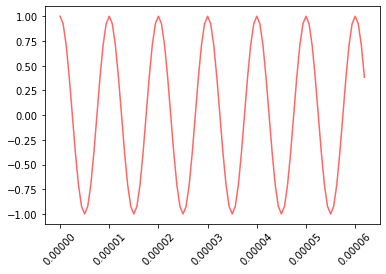

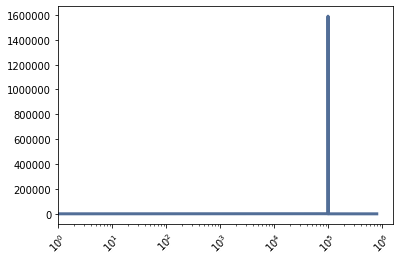

In [11]:
LO_complex = Channel(np.exp(1j * PI2 * freq_lo * t), ts = t, framerate = freq_sampling) 
LO_cos     = Channel(np.cos(PI2 * freq_lo * t), ts = t, framerate = freq_sampling) 
LO_sin     = Channel(np.sin(PI2 * freq_lo * t), ts = t, framerate = freq_sampling) 

show_wav_n_spectrum(LO_complex, 100, (1, freq_sampling))

## IF

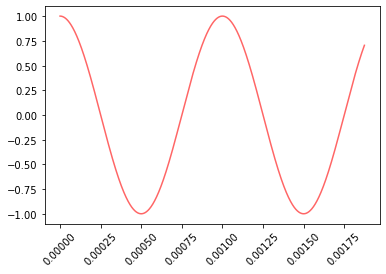

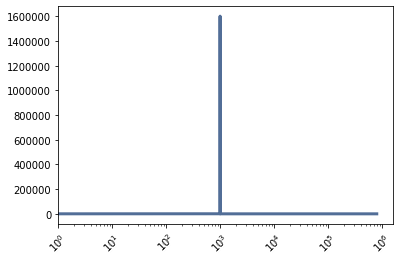

In [12]:
freq_if = 1000

IF = Channel(np.exp(1j * PI2 * freq_if * t), ts = t, framerate = freq_sampling) 
show_wav_n_spectrum(IF, 3000, (1, freq_sampling))

## RF (Modulation)

#### 用複數訊號做 shifter:
- IF 被完美的 shift 到新的 頻率
- new frequency = freq_IF + freq_LO，能量不變
- $e^{j\omega_1 t} * e^{j\omega_2 t} = e^{j(\omega_1 + \omega_2 ) t}$

In [13]:
# fm = FrequencyMixer(freq = freq_lo, fun = np.exp)

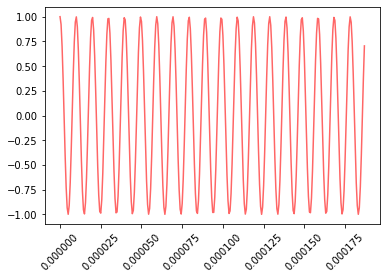

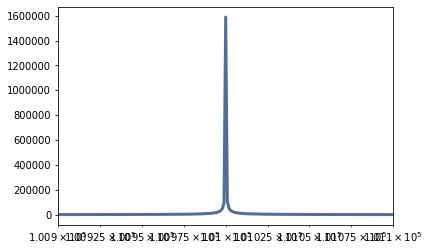

In [14]:
# RF = IF * LO_complex  
RF = FrequencyMixer(freq = freq_lo, fun = np.exp).modulate(FrequencyMixer(freq_if).gen_channel(t, np.exp)) 
show_wav_n_spectrum(RF, 300,  (freq_lo + freq_if - freq_if/10 , freq_lo + freq_if + freq_if/10))
# show_wav_n_spectrum(RF, 300,  (1, freq_sampling))

## 用 $cosine$ 訊號做 shifter:
- IF 被 shift 到 以 LO頻率 為中心的 正負 IF頻率
- new frequency = (freq_IF - freq_LO) + (freq_IF + freq_LO)，能量均分  

#### 三角函數的乘法:  

$
\begin{align}
 \sin(x) \cos(y) &= (1/2) [\sin(x+y) + \sin(x-y)] \\ 
 \cos(x) \sin(y) &= (1/2) [\sin(x+y) - \sin(x-y)] \\ 
 \cos(x) \cos(y) &= (1/2) [\cos(x-y) + \cos(x+y)] \\ 
 \sin(x) \sin(y) &= (1/2) [\cos(x-y) - \cos(x+y)] \\  
\end{align}
$  

####  用 cosine 訊號 對 exp 訊號 做 shifter:  

$
\begin{align}
 \cos({\omega_1 t}) \cdot e^{j\omega_2 t} &= \cos(\omega_1 t) \cdot (\cos(\omega_2 t) + j\sin(\omega_2 t)) \\ 
 &= \cos(\omega_1 t) \cos(\omega_2 t) + j\cos(\omega_1 t)\sin(\omega_2 t) \\ 
 &= \frac{1}{2} (\cos((\omega_1 - \omega_2) t) + \cos((\omega_1 + \omega_2) t)) + \frac{1}{2}j \cdot(\sin((\omega_1 + \omega_2) t) -\sin((\omega_1 - \omega_2) t))) \\ 
 &= \frac{1}{2} (\cos((\omega_1 - \omega_2) t) -j\sin((\omega_1 - \omega_2) t) + \cos((\omega_1 + \omega_2) t)) + j\sin((\omega_1 + \omega_2) t) ) \\ 
 &= \frac{1}{2} ((\cos((\omega_1 - \omega_2) t) -j\sin((\omega_1 - \omega_2) t)) + (\cos((\omega_1 + \omega_2) t)) + j\sin((\omega_1 + \omega_2) t))) \\ 
 &= \frac{1}{2} (e^{j(\omega_2 - \omega_1) t} + e^{j(\omega_2 + \omega_1) t}) \\ 
 &= \frac{1}{2} e^{j(\omega_2 - \omega_1) t} + \frac{1}{2}e^{j(\omega_2 + \omega_1) t} \\ 
   e^{j\omega_2 t} \cdot \cos({\omega_1 t}) &= (\cos(\omega_2 t) + j\sin(\omega_2 t)) \cdot  \cos(\omega_1 t) \\ 
 &= \cos(\omega_2 t) \cos(\omega_1 t) + j\sin(\omega_2 t)\cos(\omega_1 t) \\ 
 &= \frac{1}{2} (\cos((\omega_2 - \omega_1) t) + \cos((\omega_2 + \omega_1) t)) + \frac{1}{2}j \cdot(\sin((\omega_2 + \omega_1) t) +\sin((\omega_2 - \omega_1) t))) \\ 
 &= \frac{1}{2} (\cos((\omega_2 - \omega_1) t) + j\sin((\omega_2 - \omega_1) t) + \cos((\omega_2 + \omega_1) t)) + j\sin((\omega_2 + \omega_1) t) ) \\ 
 &= \frac{1}{2} ((\cos((\omega_2 - \omega_1) t) + j\sin((\omega_2 - \omega_1) t)) + (\cos((\omega_2 + \omega_1) t)) + j\sin((\omega_2 + \omega_1) t))) \\ 
 &= \frac{1}{2} (e^{j(\omega_2 - \omega_1) t} + e^{j(\omega_2 + \omega_1) t}) \\ 
 &= \frac{1}{2} e^{j(\omega_2 - \omega_1) t} + \frac{1}{2}e^{j(\omega_2 + \omega_1) t} \\ 
 &= \cos({\omega_1 t}) \cdot e^{j\omega_2 t}
\end{align}
$

exp 訊號的頻率必須比 cosine 訊號的頻率高 ($\omega_2 > \omega_1$)，才會在正頻譜出現兩條頻率，否則有一條頻率會出現在 負頻譜區。  

#### exp 訊號的頻率比 cosine 訊號的頻率高 ($\omega_2 > \omega_1$)

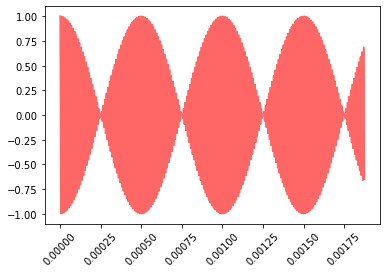

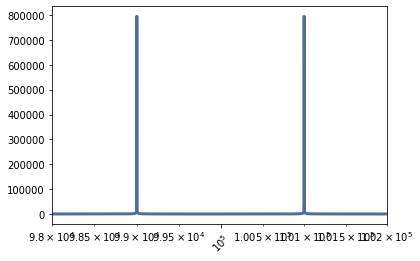

In [15]:
RF = FrequencyMixer(freq = freq_if, fun = np.cos).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.exp)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

#### exp 訊號的頻率比 cosine 訊號的頻率高 ($\omega_2 > \omega_1$)

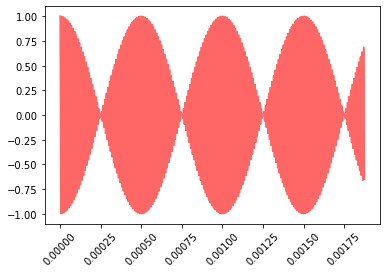

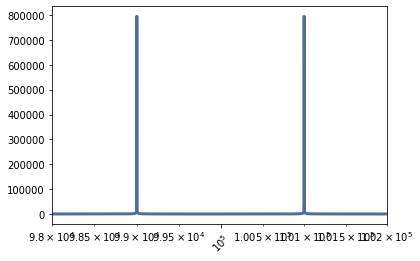

In [16]:
RF = FrequencyMixer(freq = freq_lo, fun = np.exp).modulate(FrequencyMixer(freq_if).gen_channel(t, np.cos)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

#### exp 訊號的頻率比 cosine 訊號的頻率低 ($\omega_2 < \omega_1$)

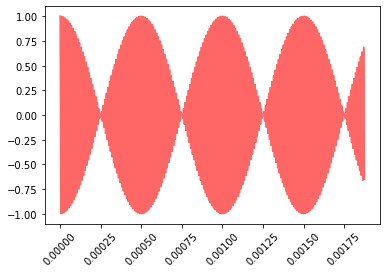

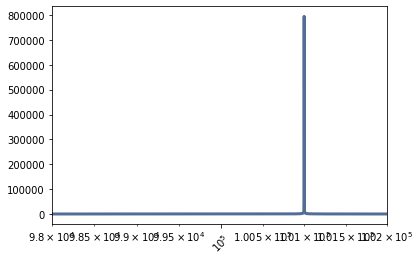

In [17]:
RF = FrequencyMixer(freq = freq_if, fun = np.exp).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.cos)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

##  用 sine 訊號做 shifter:  

$
\begin{align}
\sin({\omega_1 t}) &=\cos({\omega_1 t  - \frac{\pi}{2}}) \\
 \sin({\omega_1 t}) \cdot e^{j\omega_2 t} &= \cos({\omega_1 t - \frac{\pi}{2}}) \cdot e^{j\omega_2 t} \\
 &= \frac{1}{2} e^{j((\omega_2 - \omega_1) t- \frac{\pi}{2})} + \frac{1}{2}e^{j((\omega_2 + \omega_1) t- \frac{\pi}{2})} \\ 
\end{align}
$

#### exp 訊號的頻率比 sine 訊號的頻率高 ($\omega_2 > \omega_1$)

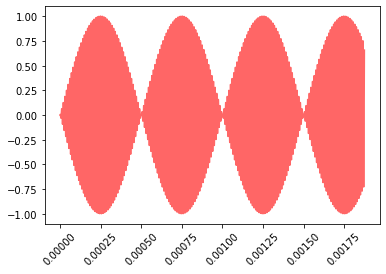

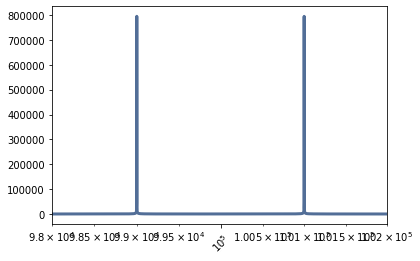

In [18]:
RF = FrequencyMixer(freq = freq_if, fun = np.sin).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.exp)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

#### exp 訊號的頻率比 sine 訊號的頻率高 ($\omega_2 > \omega_1$)

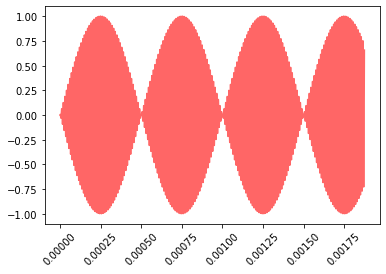

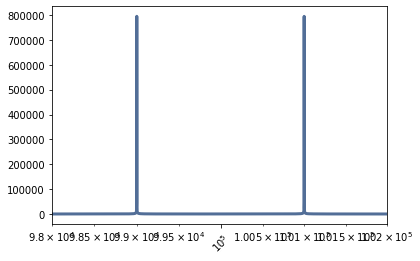

In [19]:
RF = FrequencyMixer(freq = freq_lo, fun = np.exp).modulate(FrequencyMixer(freq_if).gen_channel(t, np.sin)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

#### exp 訊號的頻率比 sine 訊號的頻率低 ($\omega_2 < \omega_1$)

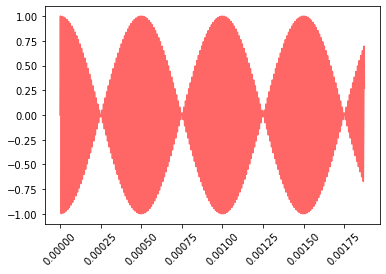

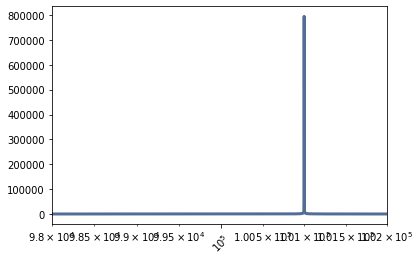

In [20]:
RF = FrequencyMixer(freq = freq_if, fun = np.exp).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.sin)) 
show_wav_n_spectrum(RF, 3000,  (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

## 使用 Sine / Cosine 來做 shifter，效果一樣，但是 phase shift 90度

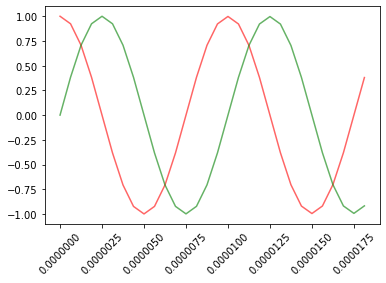

In [21]:
show_pair(FrequencyMixer(freq = freq_if, fun = np.exp).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.cos)),
          FrequencyMixer(freq = freq_if, fun = np.exp).modulate(FrequencyMixer(freq_lo).gen_channel(t, np.sin)),
          frames = 30)